In [1]:
# ------------------- 1. Import Libraries -------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from keras.callbacks import EarlyStopping

In [2]:
# ------------------- 2. Load and Clean Dataset -------------------
df = pd.read_csv("Google_Stock_Price_Train.csv")
df.columns = [col.strip() for col in df.columns]

In [3]:
# Safely convert 'Open' to float
if df['Open'].dtype == 'object':
    df['Open'] = df['Open'].str.replace(',', '').astype(float)

df.dropna(inplace=True)

In [7]:
# ------------------- 3. Remove Outliers -------------------
Q1 = df['Open'].quantile(0.25)
Q3 = df['Open'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Open'] >= lower_bound) & (df['Open'] <= upper_bound)]

In [9]:
# ------------------- 4. Feature Scaling -------------------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Open']])

In [11]:
# ------------------- 5. Create Sequences -------------------
def create_dataset(data, time_step=60):
    x, y = [], []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i])
        y.append(data[i])
    return np.array(x), np.array(y)

x, y = create_dataset(scaled_data)
x = x.reshape((x.shape[0], x.shape[1], 1))

In [13]:
# ------------------- 6. Train/Test Split -------------------
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [15]:
# ------------------- 7. Build SimpleRNN Model -------------------
model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=80))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop])


Epoch 1/50


C:\Users\yashd\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.2879 - mae: 0.3854 - val_loss: 0.0048 - val_mae: 0.0546
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0389 - mae: 0.1539 - val_loss: 0.0185 - val_mae: 0.1261
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0226 - mae: 0.1170 - val_loss: 0.0046 - val_mae: 0.0572
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0160 - mae: 0.0964 - val_loss: 0.0240 - val_mae: 0.1469
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0126 - mae: 0.0864 - val_loss: 0.0023 - val_mae: 0.0386
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0100 - mae: 0.0738 - val_loss: 0.0055 - val_mae: 0.0643
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0082 - mae: 0.0678 - val_loss: 0.0025 - val_mae: 0.0415
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072 - mae: 0.0634 - val_loss: 0.0021 - val_mae: 0.0375
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0072 - mae: 0.

In [16]:
# ------------------- 8. Predictions -------------------
y_pred = model.predict(x_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [19]:
# ------------------- 9. Evaluation -------------------
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

def stock_prediction_accuracy(y_true, y_pred, tolerance=32):
    correct = np.abs(y_true - y_pred) <= tolerance
    return np.mean(correct)

accuracy = stock_prediction_accuracy(y_test_inv, y_pred_inv)
print(f"Custom Accuracy (±$32): {accuracy:.2%}")

MAE: 23.22
RMSE: 26.66
R² Score: 0.42
Custom Accuracy (±$32): 75.83%


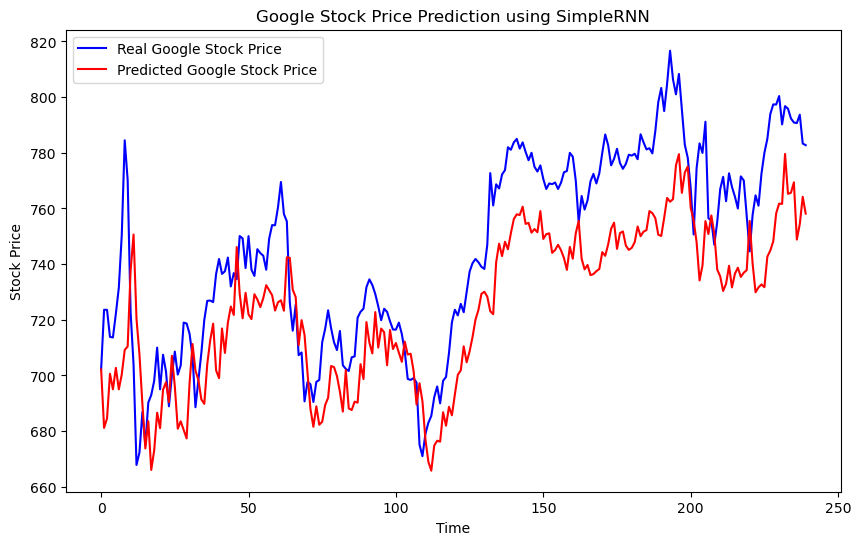

In [21]:
# ------------------- 10. Plot Results -------------------
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, color='blue', label='Real Google Stock Price')
plt.plot(y_pred_inv, color='red', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction using SimpleRNN')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()